## Simple example of TuRBO-m

In [2]:
import sys
sys.path.append('/home/aditya/Documents/TuRBO-master')

from turbo.turbo_m import TurboM

import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt

## Set up an optimization problem class

In [3]:
class Levy:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub = 10 * np.ones(dim)
        self.query_count = 0  # Initialize query counter
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        # Increment the query counter
        self.query_count += 1
        
        w = 1 + (x - 1.0) / 4.0
        val = np.sin(np.pi * w[0]) ** 2 + \
            np.sum((w[1:self.dim - 1] - 1) ** 2 * (1 + 10 * np.sin(np.pi * w[1:self.dim - 1] + 1) ** 2)) + \
            (w[self.dim - 1] - 1) ** 2 * (1 + np.sin(2 * np.pi * w[self.dim - 1])**2)
        return val


f = Levy(10)

## Create a Turbo optimizer instance

In [4]:
turbo_m = TurboM(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=10,  # Number of initial bounds from an Symmetric Latin hypercube design
    max_evals=1000,  # Maximum number of evaluations
    n_trust_regions=5,  # Number of trust regions
    batch_size=10,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

Using dtype = torch.float64 
Using device = cpu


# Run the optimization process

In [5]:
turbo_m.optimize()

TR-0 starting from: 16.29
TR-1 starting from: 24.83
TR-2 starting from: 18.03
TR-3 starting from: 21.42
TR-4 starting from: 26.62
100) New best @ TR-2: 15.55
120) New best @ TR-1: 11.06
150) New best @ TR-1: 10.58
170) New best @ TR-1: 9.42
200) New best @ TR-2: 8.614
220) New best @ TR-1: 1.53
220) New best @ TR-2: 4.838
350) New best @ TR-1: 1.281
360) New best @ TR-1: 0.8445
380) New best @ TR-1: 0.6371
390) New best @ TR-1: 0.5265
400) New best @ TR-1: 0.4252
440) New best @ TR-1: 0.3632
470) New best @ TR-1: 0.3357
500) New best @ TR-1: 0.3206
510) New best @ TR-1: 0.3034
520) New best @ TR-1: 0.3026
550) New best @ TR-1: 0.2714
570) New best @ TR-1: 0.2648
590) New best @ TR-1: 0.2501
600) New best @ TR-1: 0.2316
620) TR-1 converged to: : 0.2314
620) TR-1 is restarting from: : 18.76
870) TR-2 converged to: : 0.6094
870) TR-2 is restarting from: : 29.08


In [6]:
# After optimization process
print("Total number of queries to the black box function:", f.query_count)

Total number of queries to the black box function: 1000


## Extract all evaluations from Turbo and print the best

In [7]:
X = turbo_m.X  # Evaluated points
fX = turbo_m.fX  # Observed values
ind_best = np.argmin(fX)
f_best, x_best = fX[ind_best], X[ind_best, :]

print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))

Best value found:
	f(x) = 0.231
Observed at:
	x = [ 1.096 -0.17   0.738  1.091  0.983  0.869  1.051 -0.174  0.944  1.169]


/tmp/ipykernel_23565/3857413194.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))


## Plot the progress

TuRBO-5 converges to a solution close to the global optimum

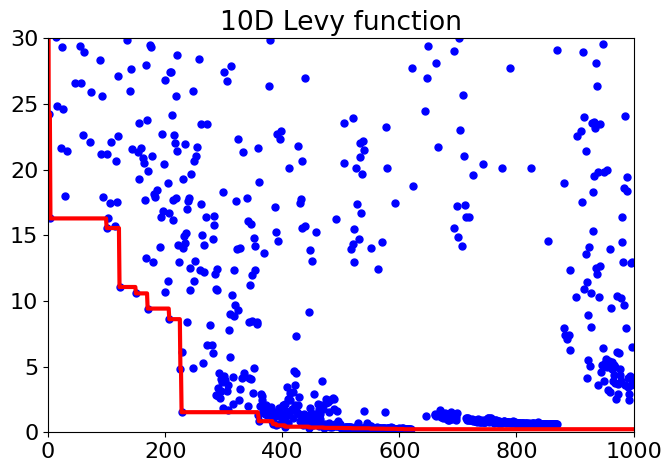

In [8]:
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(fX, 'b.', ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(fX), 'r', lw=3)  # Plot cumulative minimum as a red line
plt.xlim([0, len(fX)])
plt.ylim([0, 30])
plt.title("10D Levy function")

plt.tight_layout()
plt.show()